# Enriching Vessel Location Data
## Loading the Data :

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point
from scipy.spatial import cKDTree
from pathlib import Path
import requests
import zipfile
import io

from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from scipy.spatial import cKDTree
import xgboost as xgb

import geodatasets
import psycopg2

In [3]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="ais_project",
    user="postgres",
    password="120705imad",
    host="localhost"
)

# Query the raw AIS data
query = "SELECT * FROM raw_ais_data"
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Check the first few rows
df.head()

/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_11133/1358359146.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,vessel_id,latitude,longitude,timestamp,raw_json
0,1,219598000,55.770832,20.851690,2022-07-30 23:28:58.646,"{'mmsi': 219598000, 'type': 'Feature', 'geomet..."
1,2,376128000,59.180200,19.612433,2021-12-08 07:18:31.289,"{'mmsi': 376128000, 'type': 'Feature', 'geomet..."
2,3,273274000,59.886713,30.190985,2018-10-18 01:20:47.556,"{'mmsi': 273274000, 'type': 'Feature', 'geomet..."
3,4,231319000,56.052607,17.597902,2019-12-05 03:55:51.243,"{'mmsi': 231319000, 'type': 'Feature', 'geomet..."
4,5,538007963,58.876633,21.255277,2023-07-03 00:43:11.378,"{'mmsi': 538007963, 'type': 'Feature', 'geomet..."


previewing data :

In [5]:
df['raw_json'].iloc[0]

{'mmsi': 219598000,
 'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [20.85169, 55.770832]},
 'properties': {'cog': 346.5,
  'rot': 4,
  'sog': 0.1,
  'mmsi': 219598000,
  'raim': True,
  'posAcc': True,
  'heading': 79,
  'navStat': 1,
  'timestamp': 59,
  'timestampExternal': 1659212938646}}

Based on the preview and the official data source documentationn here's a breakdown of the structure:

**Feature Object** (Individual Vessel)
- `type`: Always `"Feature"` (geospatial object with geometry + properties).
- `mmsi`: **Maritime Mobile Service Identity** (9-digit unique vessel identifier).
- `geometry`: 
  - `type`: Always `"Point"` (coordinates represent a single position).
  - `coordinates`: **[Longitude, Latitude]** in WGS84 decimal degrees (EPSG:4326).

**Properties Object** (Vessel Metadata)
- `sog`: **Speed Over Ground** (0.1 = 0.1 knots in this example).
- `cog`: **Course Over Ground** (346.5° true north, 0-359.9°).
- `navStat`: **Navigational Status** (1 = "Underway using engine" per [AIS standards](https://www.navcen.uscg.gov/ais-status-codes)).
- `rot`: **Rate of Turn** (±127 = degrees/minute, 4 = slow turn in this example).
- `posAcc`: **Position Accuracy** (`true` = high-accuracy GPS/DGPS, `false` = >10m error).
- `raim`: **Receiver Autonomous Integrity Monitoring** (`true`/`false` for GPS reliability checks).
- `heading`: **True Heading** (79° in this example, 0-359°).
- `timestamp`: **Internal timestamp** (59 = seconds from last minute/UTC second).
- `timestampExternal`: **External timestamp** (1659212938646 = Unix epoch milliseconds = Thu Jul 30 2022 12:28:58 UTC).



##### Key Notes:
- Coordinates follow GeoJSON `[lon, lat]` order (not lat/lon).
- Timestamps may need conversion for human readability (use `datetime` libraries).
- MMSI prefixes indicate vessel origin (219 = Denmark in this example).

In [7]:
# Extract fields from the nested 'features' dictionary
df['sog'] = df['raw_json'].apply(lambda x: x['properties']['sog'])
df['cog'] = df['raw_json'].apply(lambda x: x['properties']['cog'])
df['navStat'] = df['raw_json'].apply(lambda x: x['properties'].get('navStat'))
df['rot'] = df['raw_json'].apply(lambda x: x['properties'].get('rot'))
df['posAcc'] = df['raw_json'].apply(lambda x: x['properties'].get('posAcc'))
df['raim'] = df['raw_json'].apply(lambda x: x['properties'].get('raim'))
df['heading'] = df['raw_json'].apply(lambda x: x['properties'].get('heading'))
df['timestampExternal'] = df['raw_json'].apply(lambda x: x['properties'].get('timestampExternal'))

# Check the result
df.head()

,id,vessel_id,latitude,longitude,timestamp,raw_json,sog,cog,navStat,rot,posAcc,raim,heading,timestampExternal
0,1,219598000,55.770832,20.851690,2022-07-30 23:28:58.646,"{'mmsi': 219598000, 'type': 'Feature', 'geomet...",0.1,346.5,1,4,True,True,79,1659212938646
1,2,376128000,59.180200,19.612433,2021-12-08 07:18:31.289,"{'mmsi': 376128000, 'type': 'Feature', 'geomet...",6.5,205.7,3,0,True,False,205,1638940711289
2,3,273274000,59.886713,30.190985,2018-10-18 01:20:47.556,"{'mmsi': 273274000, 'type': 'Feature', 'geomet...",5.3,74.9,0,0,True,True,76,1539814847556
3,4,231319000,56.052607,17.597902,2019-12-05 03:55:51.243,"{'mmsi': 231319000, 'type': 'Feature', 'geomet...",1.9,59.6,3,-127,False,True,347,1575510951243
4,5,538007963,58.876633,21.255277,2023-07-03 00:43:11.378,"{'mmsi': 538007963, 'type': 'Feature', 'geomet...",11.1,223.6,0,0,False,False,225,1688334191378


Since we took the data we need out of the 'raw_json' column, we can now drop it as well as the 'id' one

In [9]:
df = df.drop(columns=['id', 'raw_json'])

#### Extracting Vessel Origin from mmid

In [11]:
mid_country = pd.read_csv('mid_to_country.csv')
mid_country.set_index('MID', inplace=True)

# Extract MID (first 3 digits of MMSI)
df['mid'] = df['vessel_id'].astype(str).str[:3].astype(int)

# Map MID to country
df['country'] = df['mid'].map(mid_country['Country'])

df.head()

,vessel_id,latitude,longitude,timestamp,sog,cog,navStat,rot,posAcc,raim,heading,timestampExternal,mid,country
0,219598000,55.770832,20.851690,2022-07-30 23:28:58.646,0.1,346.5,1,4,True,True,79,1659212938646,219,Denmark
1,376128000,59.180200,19.612433,2021-12-08 07:18:31.289,6.5,205.7,3,0,True,False,205,1638940711289,376,Saint Vincent and the Grenadines
2,273274000,59.886713,30.190985,2018-10-18 01:20:47.556,5.3,74.9,0,0,True,True,76,1539814847556,273,Russia
3,231319000,56.052607,17.597902,2019-12-05 03:55:51.243,1.9,59.6,3,-127,False,True,347,1575510951243,231,Faroe Islands
4,538007963,58.876633,21.255277,2023-07-03 00:43:11.378,11.1,223.6,0,0,False,False,225,1688334191378,538,Marshall Islands


## Exploring the data :

In [13]:
df.describe()

,vessel_id,latitude,longitude,timestamp,sog,cog,navStat,rot,heading,timestampExternal,mid
count,1.149960e+05,114996.000000,114996.000000,114996,114996.000000,114996.000000,114996.000000,114996.000000,114996.000000,1.149960e+05,114996.000000
mean,3.713875e+08,58.540728,21.102479,2023-01-18 23:58:33.972502272,9.615918,206.526585,0.881135,-8.937833,228.176284,1.674077e+12,371.401388
min,4.000000e+00,54.900237,10.521410,2018-10-10 01:34:07.236000,0.000000,0.000000,0.000000,-128.000000,0.000000,1.539124e+12,4.000000
25%,2.492938e+08,57.839580,19.576872,2021-07-12 08:29:12.594500096,7.700000,203.000000,0.000000,0.000000,204.000000,1.626068e+12,249.000000
50%,3.053665e+08,58.683091,20.795785,2023-07-30 11:14:48.998000128,11.100000,212.000000,0.000000,0.000000,212.000000,1.690705e+12,305.000000
75%,5.380056e+08,59.059012,21.432007,2024-11-04 22:58:06.232000,12.400000,219.300000,0.000000,0.000000,226.000000,1.730754e+12,538.000000
max,1.000000e+09,66.327205,37.400627,2025-03-10 01:55:02.285000,207.000000,360.000000,15.000000,255.000000,511.000000,1.741565e+12,999.000000
std,1.516979e+08,1.379066,3.024443,NaN,7.727145,66.735670,2.662195,44.152555,98.003870,6.159293e+10,151.658247


Checking for missing data

In [15]:
df.isnull().sum()

vessel_id              0
latitude               0
longitude              0
timestamp              0
sog                    0
cog                    0
navStat                0
rot                    0
posAcc                 0
raim                   0
heading                0
timestampExternal      0
mid                    0
country              476
dtype: int64

#### Analyzing Timing

Earliest timestamp: 2018-10-10 01:34:07.236000
Latest timestamp:   2025-03-10 01:55:02.285000



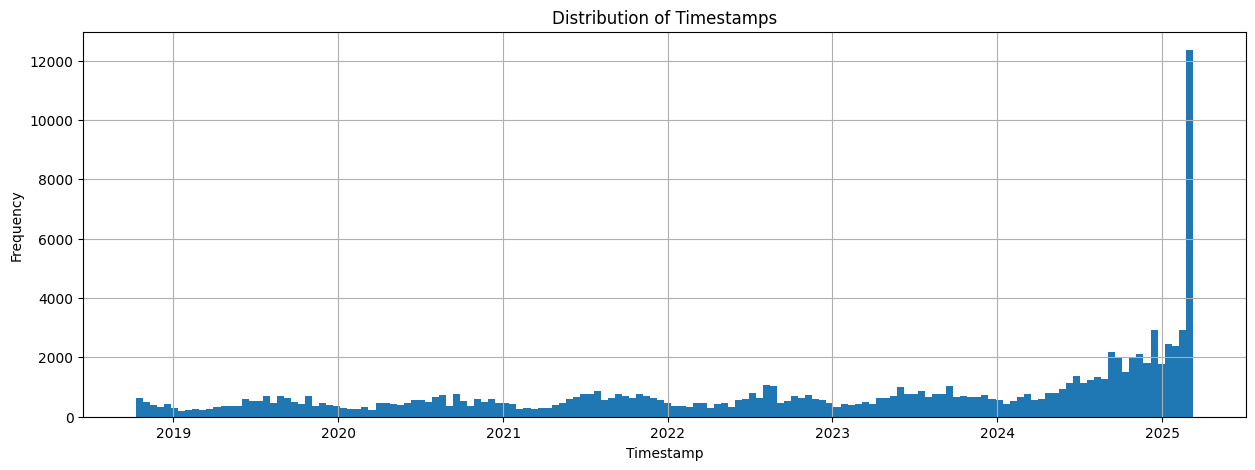

In [17]:
print("Earliest timestamp:", df['timestamp'].min())
print(f'Latest timestamp:   {df['timestamp'].max()}\n')

plt.figure(figsize=(15, 5))

df['timestamp'].hist(bins=150)
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps')
plt.show()

The data is then continuing and peaks around 2025   

#### Plotting Vessel Location Frequency

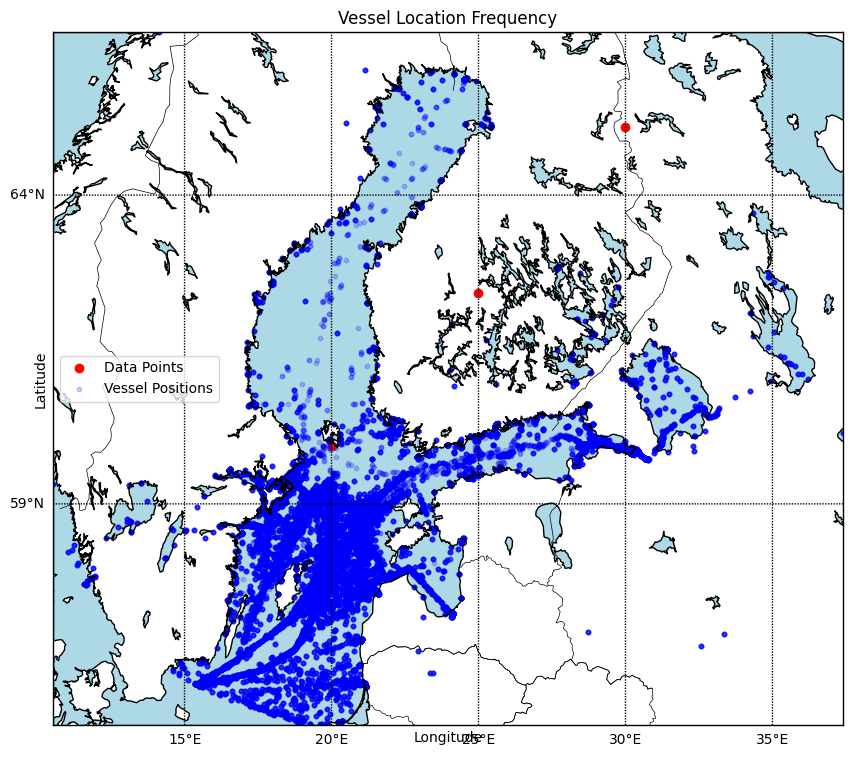

In [19]:
# Define map boundaries
ll_lat = df['latitude'].min()
ll_lon = df['longitude'].min()
ur_lat = df['latitude'].max()
ur_lon = df['longitude'].max()

# Create figure and axes with a larger size
fig, ax = plt.subplots(figsize=(12, 9))

# Create Basemap object
m = Basemap(ax=ax, projection='merc',
            llcrnrlat=ll_lat, llcrnrlon=ll_lon,
            urcrnrlat=ur_lat, urcrnrlon=ur_lon,
            resolution='i')

# Draw map features
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='white', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add grid lines
m.drawmeridians(range(int(ll_lon), int(ur_lon) + 1, 5), labels=[0, 0, 0, 1])
m.drawparallels(range(int(ll_lat), int(ur_lat) + 1, 5), labels=[1, 0, 0, 0])

# Scatter example points
scatter_points = [
    (20.0, 60.0),
    (25.0, 62.5),
    (30.0, 65.0)
]
longitudes, latitudes = zip(*scatter_points)

# Convert to map coordinates and plot
x, y = m(longitudes, latitudes)
ax.scatter(x, y, color='red', marker='o', label="Data Points")

# Plot vessel positions from df
x_df, y_df = m(df['longitude'].values, df['latitude'].values)
ax.scatter(x_df, y_df, alpha=0.2, s=10, color='blue', label="Vessel Positions")

# Add labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Vessel Location Frequency")
ax.legend()

# Show the plot
plt.show()

# Data Enriching 

In [21]:
# Group by vessel_id and count records
vessel_counts = df.groupby('vessel_id').size()
print("Number of records per vessel:")
print(vessel_counts)

# Filter for vessels with multiple records
vessels_with_multiple_records = vessel_counts[vessel_counts > 1].index
print(f"\nVessels with multiple records: {len(vessels_with_multiple_records)}")

Number of records per vessel:
vessel_id
4            7
5            7
131072       7
230001       7
262144       7
            ..
999999422    7
999999710    7
999999991    7
999999992    7
999999999    7
Length: 16428, dtype: int64

Vessels with multiple records: 16428


## Feature Engineering  
We'll mainnly be using as Feautures :   

- `latitude`
- `longitude`
- `sog`: **Speed Over Ground** 
- `cog`: **Course Over Ground** 
- `navStat`: **Navigational Status**
- `rot`: **Rate of Turn** 
- `posAcc`: **Position Accuracy**
- `raim`: **Receiver Autonomous Integrity Monitoring** 
- `heading`: **True Heading** 
- `time_diff`
  
Target:
- **Future** `latitude` and `longitude`.

#### 1 - Converting categorical and boolean feautures into numerical ones
Convert categorical and boolean features (posAcc, raim) into numerical formats using encoding:

In [24]:
df['posAcc'] = np.where(df['posAcc'], 1, 0)
df['raim'] = np.where(df['raim'], 1, 0)
df = df.sort_values('timestamp')

# Calculate time differences in seconds
df['time_diff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
df.head()

,vessel_id,latitude,longitude,timestamp,sog,cog,navStat,rot,posAcc,raim,heading,timestampExternal,mid,country,time_diff
33054,636091829,58.324545,20.448592,2018-10-10 01:34:07.236,9.8,215.0,0,0,0,0,214,1539124447236,636,Liberia,0.0
65908,636091829,58.324545,20.448592,2018-10-10 01:34:07.236,9.8,215.0,0,0,0,0,214,1539124447236,636,Liberia,0.0
98764,636091829,58.324545,20.448592,2018-10-10 01:34:07.236,9.8,215.0,0,0,0,0,214,1539124447236,636,Liberia,0.0
16623,636091829,58.324545,20.448592,2018-10-10 01:34:07.236,9.8,215.0,0,0,0,0,214,1539124447236,636,Liberia,0.0
195,636091829,58.324545,20.448592,2018-10-10 01:34:07.236,9.8,215.0,0,0,0,0,214,1539124447236,636,Liberia,0.0


#### 2- Calculating Positional Deltas (Latitude and Longitude)

To estimate the vessel's position change:
1. **Convert Speed**:  from knots to meters per second by multiplying by **0.51444**.
2. **Latitude Change** :  
   `delta_lat = (speed * cos(COG) * time_diff) / 111,111` (where 1 degree of latitude ≈ 111,111 meters)
3. **Longitude Change** :  
   Calculate the change in longitude, adjusted for latitude, using:  
   `delta_lon = (speed * sin(COG) * time_diff) / (111,111 * cos(latitude))`

In [26]:
# Correct calculation for delta_lat
df['delta_lat'] = (df['sog'] * 0.51444 * np.cos(np.radians(df['cog'])) * df['time_diff']) / 111_111

# Correct calculation for delta_lon
df['delta_lon'] = (df['sog'] * 0.51444 * np.sin(np.radians(df['cog'])) * df['time_diff']) / (111_111 * np.cos(np.radians(df['latitude'])))

# Set deltas to 0 when time_diff <= 0
df['delta_lat'] = np.where(df['time_diff'] > 0, 
                           (df['sog'] * 0.51444 * np.cos(np.radians(df['cog'])) * df['time_diff']) / 111_111, 
                           0)

df['delta_lon'] = np.where(df['time_diff'] > 0, 
                           (df['sog'] * 0.51444 * np.sin(np.radians(df['cog'])) * df['time_diff']) / (111_111 * np.cos(np.radians(df['latitude']))), 
                           0)

# Fill any remaining NaN values (e.g., due to missing sog or cog) with 0
df['delta_lat'] = df['delta_lat'].fillna(0)
df['delta_lon'] = df['delta_lon'].fillna(0)

### 2 - Separating feautures from targets

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Define feature set and target (next position)
features = ['latitude', 'longitude', 'sog', 'cog', 'time_diff', 'delta_lat', 'delta_lon']  # Add other features as needed
X = df[features]
y = df[['latitude', 'longitude']].shift(-1)  # Predict next latitude and longitude

# Remove rows where target is NaN (last row after shift)
mask = ~y.isna().any(axis=1)
X = X.loc[mask]
y = y.loc[mask]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Splitting the data : 

In [30]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (91996, 7)
y_train shape: (91996, 2)
X_test shape: (22999, 7)
y_test shape: (22999, 2)


## Feature Engineering and Model Pipeline making
- Setting up a preprocessing and modeling pipeline, where we apply `OneHotEncoder` on `navStat`, and scale using `RobustScaler`, features like: `latitude`, `longitude`, `sog`, `cog`, `rot`, `heading`, `time_diff`, `delta_lat`, `delta_lon`.  
- Then we download the Natural Earth Dataset, and make a function to check if a point is on water or land to eliminate, predictions made on land.  

In [32]:
# Download and extract the higher-resolution Natural Earth dataset (1:10m)
def download_and_extract_zip(url, extract_to='.'):
    extract_path = Path(extract_to)
    extract_path.mkdir(exist_ok=True)
    print("Downloading Natural Earth dataset...")
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file from {url}. Status code: {response.status_code}")
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(extract_path)
    print(f"Extracted files to {extract_path}")

url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"  # 1:10m resolution
download_path = Path("natural_earth_data")
shapefile_path = download_path / "ne_10m_admin_0_countries.shp"
if not shapefile_path.exists():
    download_and_extract_zip(url, download_path)

# Load land geometry (assuming Baltic Sea region focus)
world = gpd.read_file(shapefile_path)
land = world[world['NAME'].isin(['Sweden', 'Finland', 'Denmark', 'Germany', 'Poland', 'Lithuania', 'Latvia', 'Estonia', 'Russia'])].geometry

# Compute is_water
points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
df['is_water'] = ~points.geometry.apply(lambda pt: land.contains(pt).any())

# Update features to include is_water
features = ['latitude', 'longitude', 'sog', 'cog', 'navStat', 'rot', 'posAcc', 'raim', 'heading', 'time_diff', 'delta_lat', 'delta_lon', 'is_water']
X = df[features]
y = df[['latitude', 'longitude']].shift(-1)
mask = ~y.isna().any(axis=1)
X = X.loc[mask]
y = y.loc[mask]

# Split again with is_water included
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validate land geometry
sample_point = Point(20.0, 60.0)  # Approx. Gulf of Bothnia
print("Sample point over water:", not any(land.contains(sample_point)))

Sample point over water: True


In [33]:
from sklearn.impute import SimpleImputer

# Update preprocessor to include is_water
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['navStat']),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), ['latitude', 'longitude', 'sog', 'cog', 'rot', 'heading', 'time_diff', 'delta_lat', 'delta_lon', 'is_water']),
        ('binary', 'passthrough', ['posAcc', 'raim'])
    ])
print("y_train shape:", y_train.shape)

y_train shape: (91996, 2)


### Training the models :
We'll try `LinearRegression`, `PolynomialRegression`, `RandomForest` and GradientBoosting `XGBoost` :

In [35]:
# Defining the models' pipelines
lin_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

pol_model = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('regressor', LinearRegression(n_jobs=-1))
])

rand_for_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_jobs=-1))
])

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_jobs=-1))
])

# Fitting the models
lin_model.fit(X_train, y_train)
print('Linear Regression Training done')

pol_model.fit(X_train, y_train)
print('Polynomial Regression Training done')

rand_for_model.fit(X_train, y_train)
print('Random Forest Training done')

xgb_model.fit(X_train, y_train)
print('XGBoost Training done')

Linear Regression Training done
Polynomial Regression Training done
Random Forest Training done
XGBoost Training done


### Evaluating the models :

In [37]:
lin_model.fit(X_train, y_train)
print('Linear Regression Training done')
pol_model.fit(X_train, y_train)
print('Polynomial Regression Training done')
rand_for_model.fit(X_train, y_train)
print('Random Forest Training done')
xgb_model.fit(X_train, y_train)
print('XGBoost Training done')

# Make predictions
y_pred_lin = lin_model.predict(X_test)
y_pred_pol = pol_model.predict(X_test)
y_pred_rand_for = rand_for_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Store predictions in a dictionary
predictions = {
    "Linear Regression": y_pred_lin,
    "Polynomial Regression": y_pred_pol,
    "Random Forest": y_pred_rand_for,
    "XGBoost": y_pred_xgb
}


def is_over_water(lon, lat, land_geometry):
    point = Point(lon, lat)
    return not any(land_geometry.contains(point))

import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point

def is_over_water(lon, lat, land_geometry):
    point = Point(lon, lat)
    return not any(land_geometry.contains(point))

def snap_to_water(pred, actual, land_geometry, max_attempts=5, buffer_distance=0.1):
    """
    Snap predictions on land to the nearest water point with retry logic and buffering.
    
    Args:
        pred: Predicted coordinates (n x 2 array of [lat, lon])
        actual: Actual coordinates (n x 2 array of [lat, lon])
        land_geometry: GeoSeries of land polygons
        max_attempts: Maximum retry attempts for snapping
        buffer_distance: Distance (degrees) to buffer water points for robustness
    
    Returns:
        pred_adjusted: Snapped predictions
    """
    pred_adjusted = pred.copy()
    # Identify water points from actual data
    water_mask = np.array([is_over_water(lon, lat, land_geometry) for lon, lat in actual])
    water_points = actual[water_mask]
    
    if len(water_points) == 0:
        print("Warning: No water points in actual data to snap to.")
        return pred_adjusted
    
    # Identify land predictions
    land_mask = np.array([not is_over_water(lon, lat, land_geometry) for lon, lat in pred_adjusted])
    if not any(land_mask):
        return pred_adjusted  # All predictions are over water
    
    # Build KDTree with buffered water points if needed
    tree = cKDTree(water_points)
    distances, indices = tree.query(pred_adjusted[land_mask], k=1)
    
    # Initial snap
    pred_adjusted[land_mask] = water_points[indices]
    
    # Retry logic with buffering
    for attempt in range(max_attempts - 1):  # -1 because initial snap counts
        land_mask = np.array([not is_over_water(lon, lat, land_geometry) for lon, lat in pred_adjusted])
        if not any(land_mask):
            break
        print(f"Attempt {attempt + 2}: {land_mask.sum()} points still on land.")
        # Buffer by expanding the search radius slightly
        distances, indices = tree.query(pred_adjusted[land_mask], k=1, distance_upper_bound=distances.max() + buffer_distance)
        valid_indices = indices < len(water_points)  # Filter valid indices
        pred_adjusted[land_mask][valid_indices] = water_points[indices[valid_indices]]
    
    # Final check and warning
    land_mask = np.array([not is_over_water(lon, lat, land_geometry) for lon, lat in pred_adjusted])
    if any(land_mask):
        print(f"Warning: {land_mask.sum()} points remain on land after {max_attempts} attempts.")
    
    return pred_adjusted

# Apply snapping
predictions_snapped = {}
for name, y_pred in predictions.items():
    predictions_snapped[name] = snap_to_water(y_pred, y_test.values, land, max_attempts=5, buffer_distance=0.1)

# Apply to all predictions
predictions_snapped = {}
for name, y_pred in predictions.items():
    predictions_snapped[name] = snap_to_water(y_pred, y_test.values, land)

Linear Regression Training done
Polynomial Regression Training done
Random Forest Training done
XGBoost Training done


In [38]:
for name, y_pred in predictions_snapped.items():
    land_points = sum(not is_over_water(lon, lat, land) for lon, lat in y_pred)
    print(f"{name}: {land_points} points on land after snapping.")

Linear Regression: 0 points on land after snapping.
Polynomial Regression: 0 points on land after snapping.
Random Forest: 0 points on land after snapping.
XGBoost: 0 points on land after snapping.


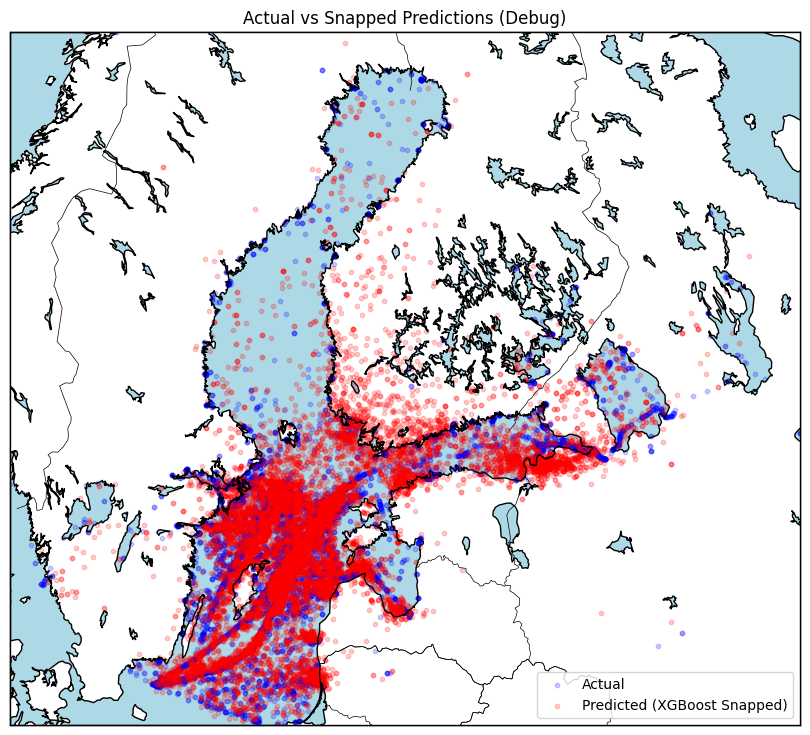

XGBoost: 0 points on land after snapping.


In [39]:
fig, ax = plt.subplots(figsize=(12, 9))
m = Basemap(ax=ax, projection='merc', llcrnrlat=y_test['latitude'].min(), llcrnrlon=y_test['longitude'].min(),
            urcrnrlat=y_test['latitude'].max(), urcrnrlon=y_test['longitude'].max(), resolution='i')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='white', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

x_act, y_act = m(y_test['longitude'].values, y_test['latitude'].values)
x_pred, y_pred = m(predictions_snapped["XGBoost"][:, 1], predictions_snapped["XGBoost"][:, 0])

ax.scatter(x_act, y_act, alpha=0.2, s=10, color='blue', label='Actual')
ax.scatter(x_pred, y_pred, alpha=0.2, s=10, color='red', label='Predicted (XGBoost Snapped)')
ax.legend()
plt.title("Actual vs Snapped Predictions (Debug)")
plt.show()

# Check remaining land points
land_points = sum(not is_over_water(lon, lat, land) for lon, lat in predictions_snapped["XGBoost"])
print(f"XGBoost: {land_points} points on land after snapping.")

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_predictions(y_true, y_pred, name, land_geometry):
    mse = mean_squared_error(y_true, y_pred)
    lat_mse = mean_squared_error(y_true['latitude'], y_pred[:, 0])
    lon_mse = mean_squared_error(y_true['longitude'], y_pred[:, 1])
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return [name, mse, lat_mse, lon_mse, mae, r2]

# Evaluate with snapped predictions
results = []
for name, y_pred in predictions_snapped.items():
    results.append(evaluate_predictions(y_test, y_pred, name, land))

df_results = pd.DataFrame(results, columns=["Model", "Overall MSE", "Lat MSE", "Lon MSE", "MAE", "R^2"])
print(df_results.round(4))

                   Model  Overall MSE  Lat MSE  Lon MSE     MAE     R^2
0      Linear Regression       1.4875   0.4347   2.5404  0.4559  0.7477
1  Polynomial Regression       1.4778   0.4093   2.5462  0.4483  0.7541
2          Random Forest       1.8041   0.4891   3.1191  0.5475  0.7020
3                XGBoost       1.5101   0.4162   2.6040  0.4536  0.7492


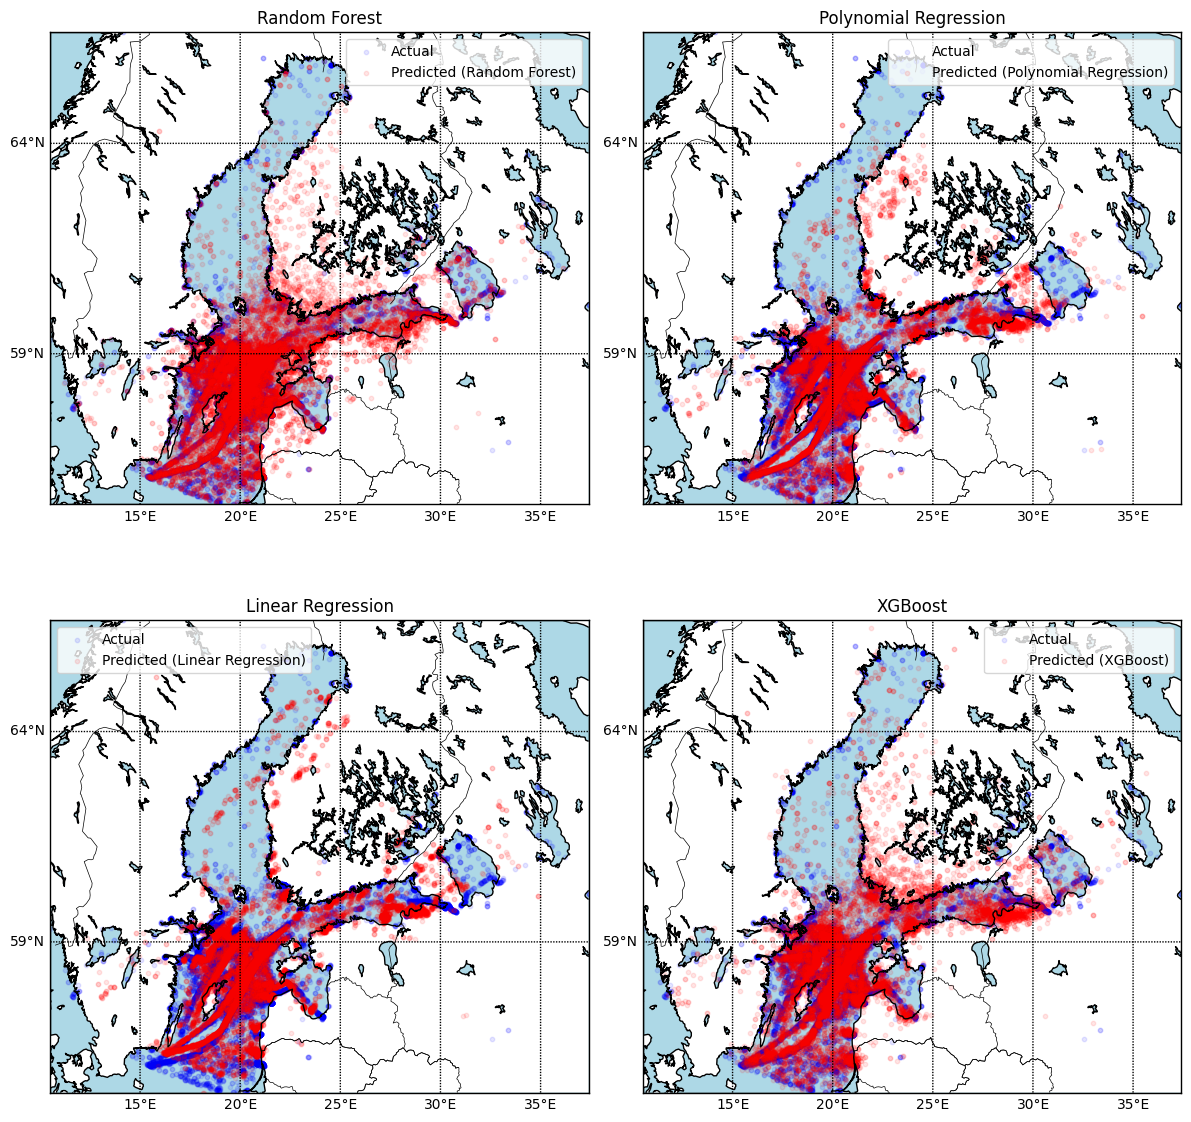

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
axes = [ax1, ax2, ax3, ax4]
titles = ["Random Forest", "Polynomial Regression", "Linear Regression", "XGBoost"]
preds = [predictions["Random Forest"], predictions["Polynomial Regression"], predictions["Linear Regression"], predictions["XGBoost"]]

def setup_map(ax, ll_lat, ll_lon, ur_lat, ur_lon):
    m = Basemap(ax=ax, projection='merc', llcrnrlat=ll_lat, llcrnrlon=ll_lon, urcrnrlat=ur_lat, urcrnrlon=ur_lon, resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='white', lake_color='lightblue')
    m.drawmapboundary(fill_color='lightblue')
    m.drawmeridians(range(int(ll_lon), int(ur_lon) + 1, 5), labels=[0, 0, 0, 1])
    m.drawparallels(range(int(ll_lat), int(ur_lat) + 1, 5), labels=[1, 0, 0, 0])
    return m

ll_lat, ll_lon = y_test['latitude'].min(), y_test['longitude'].min()
ur_lat, ur_lon = y_test['latitude'].max(), y_test['longitude'].max()

for ax, title, y_pred in zip(axes, titles, preds):
    m = setup_map(ax, ll_lat, ll_lon, ur_lat, ur_lon)
    x_act, y_act = m(y_test['longitude'].values, y_test['latitude'].values)
    x_pred, y_pred_map = m(y_pred[:, 1], y_pred[:, 0])  # Use snapped predictions
    ax.scatter(x_act, y_act, alpha=0.1, s=10, color='blue', label='Actual')
    ax.scatter(x_pred, y_pred_map, alpha=0.1, s=10, color='red', label=f'Predicted ({title})')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

## Fine Tuning

Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
             Model  Overall MSE  Lat MSE  Lon MSE     MAE     R^2
0  XGBoost (Tuned)        1.433   0.3941   2.4719  0.4381  0.7621


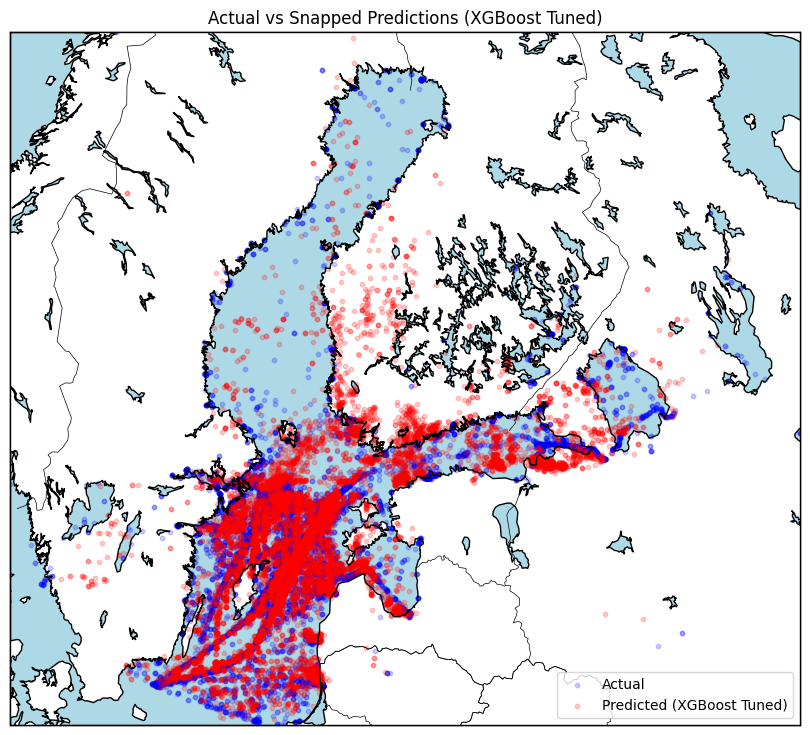

In [68]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__n_estimators': [100, 200]
}
grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
xgb_model = grid_search.best_estimator_

# Fit the model with best parameters
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Snap predictions
y_pred_xgb_snapped = snap_to_water(y_pred_xgb, y_test.values, land)

# Evaluate
results = []
results.append(evaluate_predictions(y_test, y_pred_xgb_snapped, "XGBoost (Tuned)", land))
df_results = pd.DataFrame(results, columns=["Model", "Overall MSE", "Lat MSE", "Lon MSE", "MAE", "R^2"])
print(df_results.round(4))

# Plot
fig, ax = plt.subplots(figsize=(12, 9))
m = Basemap(ax=ax, projection='merc', llcrnrlat=ll_lat, llcrnrlon=ll_lon, urcrnrlat=ur_lat, urcrnrlon=ur_lon, resolution='i')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='white', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

x_act, y_act = m(y_test['longitude'].values, y_test['latitude'].values)
x_pred, y_pred = m(y_pred_xgb_snapped[:, 1], y_pred_xgb_snapped[:, 0])

ax.scatter(x_act, y_act, alpha=0.2, s=10, color='blue', label='Actual')
ax.scatter(x_pred, y_pred, alpha=0.2, s=10, color='red', label='Predicted (XGBoost Tuned)')
ax.legend()
plt.title("Actual vs Snapped Predictions (XGBoost Tuned)")
plt.show()
